In [1]:
import os
import sys
import glob
import json
import click
import torch
import numpy as np

from PIL import Image
from PIL import ImageDraw
from torch import nn

sys.path.append("..")
from post_processing import remove_connected_components

sys.path.append("/home/amvernet/dhSegment-torch/")
from dh_segment_torch.data.annotation import AnnotationPainter, AnnotationReader, VIA2Reader
from dh_segment_torch.data import ColorLabels

%load_ext autoreload
%autoreload 2

In [2]:
images_path = "/scratch/students/amvernet/datasets/images"

predictions_path = "/scratch/students/amvernet/experiments/2_B1_000/dhSegment_predictions/0/B1_test"
cc_threshold = 0.005

predictions_path = os.path.abspath(predictions_path)
dataset_name = os.path.basename(predictions_path)
run_name = os.path.basename(os.path.dirname(predictions_path))
experiment_path = os.path.abspath(os.path.join(predictions_path, "../../.."))
experiment_name = os.path.basename(experiment_path)

color_labels = ColorLabels.from_labels_json_file(os.path.join(experiment_path, "color_labels.json"))

annotations_path = os.path.join(experiment_path, f"via_annotations_scaled_{dataset_name}.json")
with (open(annotations_path, "r")) as f:
    annotations = json.loads(f.read())

In [14]:
pid_test = "avenirgdl-1868-06-02-a-p0004"

results = {}
npy_paths = sorted(glob.glob(os.path.join(predictions_path, "npy", '*.npy')))

for path in npy_paths:
    pid = os.path.basename(path)[:-4]
    if pid == pid_test:
        results[pid] = {'img': os.path.join(images_path, pid + ".png")}

        prediction = np.load(path)
        results[pid]['pred'] = prediction
        image = Image.open(os.path.join(images_path, pid + ".png"))
        original_shape = image.width, image.height
        ground_truth = np.zeros((prediction.shape[0], original_shape[1], original_shape[0]))

        for region in annotations[pid]["regions"]:
            shape = region['shape_attributes']
            if shape['name'] == 'rect':
                x, y, w, h = shape['x'], shape['y'], shape['width'], shape['height']
                label = color_labels.labels.index(region['region_attributes']['label'])
                ground_truth[label, y:y+h, x:x+w] = 1

            elif shape['name'] == 'polygon':
                # TO VERIFY https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
                color = color_labels.labels.index(region['region_attributes']['label'])
                img = Image.new('L', original_shape, 0)
                polygon_coordinates = [(x, y) for x, y in zip(shape['all_points_x'], shape['all_points_y'])]
                ImageDraw.Draw(img).polygon(polygon_coordinates, outline=1, fill=1)
                mask = np.array(img)
                np.putmask(ground_truth[label], mask, 1)

            else:
                raise NotImplementedError

        results[pid]["gt"] = ground_truth

100%|██████████████████████████████████████| 206/206 [00:00<00:00, 12228.46it/s]


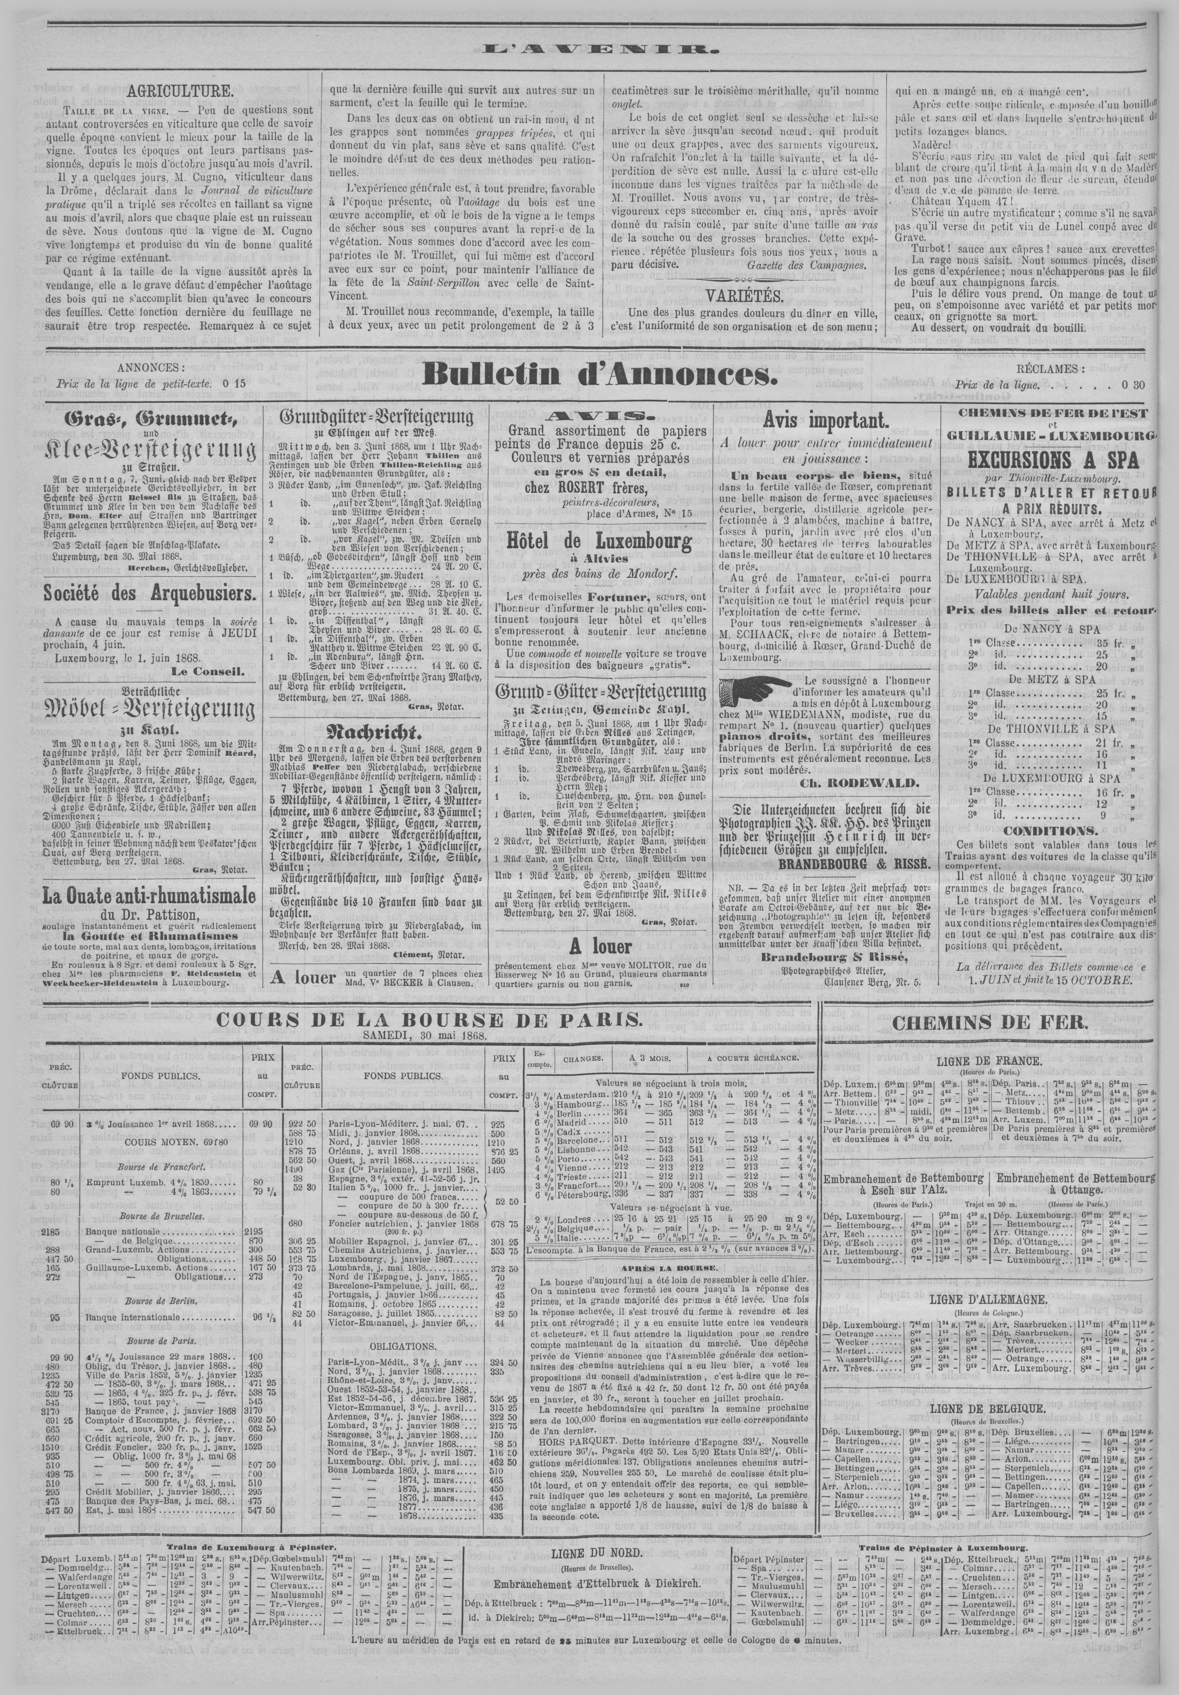

In [15]:
Image.open(os.path.join(images_path, pid_test + ".png"))

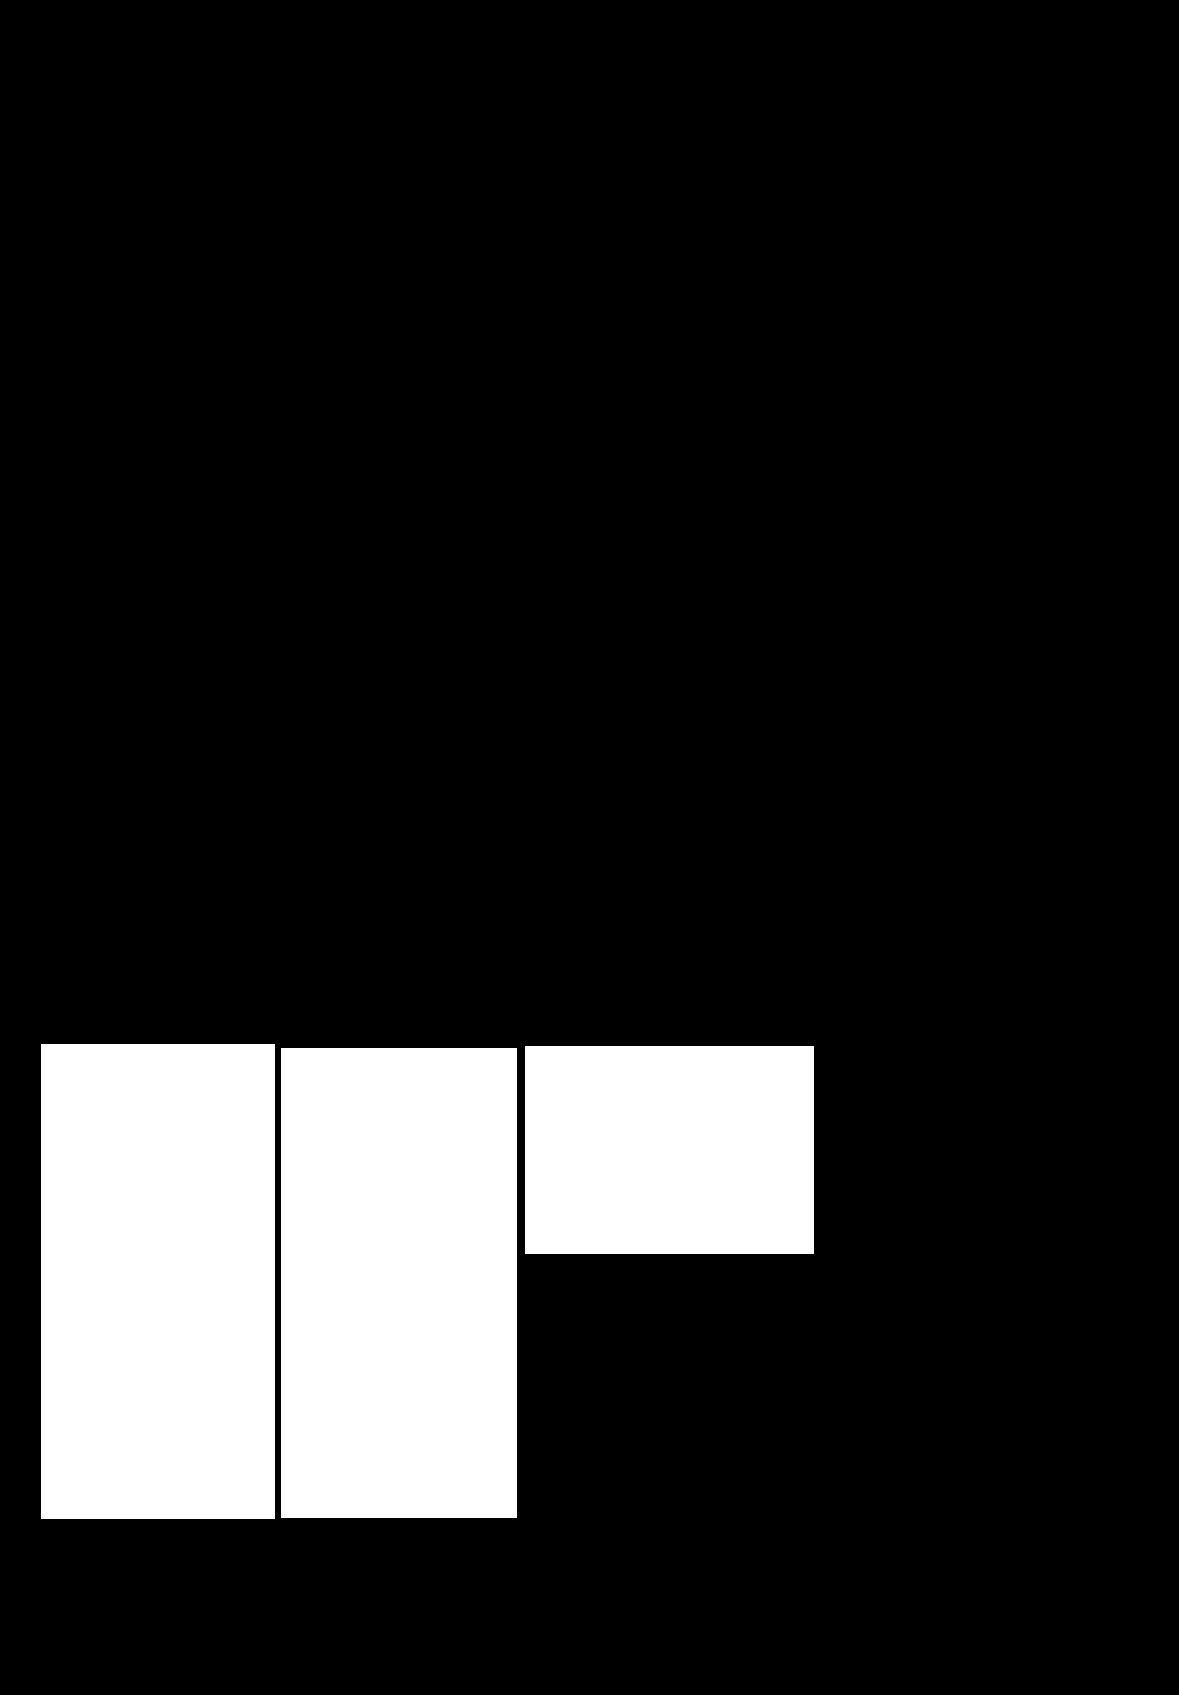

In [16]:
Image.fromarray(np.around(results[pid_test]['gt'][1]*255).astype(np.uint8))

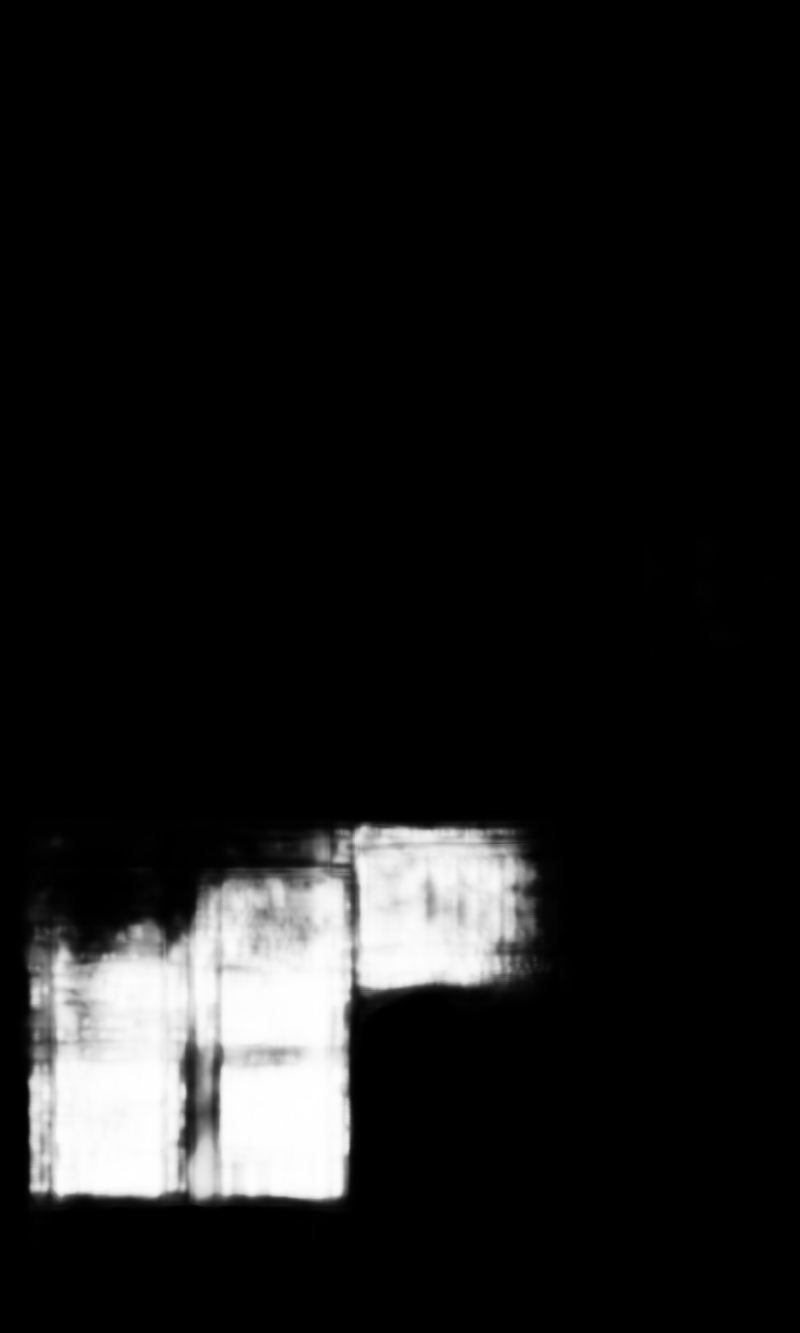

In [17]:
Image.fromarray(np.around(results[pid_test]['pred'][1]*255).astype(np.uint8))

In [18]:
result = results[pid_test]
image = Image.open(os.path.join(images_path, pid_test + ".png"))
shape = (result['gt'].shape[2], result['gt'].shape[1])
image = image.resize(shape)
image = np.asarray(image)

m = nn.Upsample(size=result['gt'].shape[1:], mode='nearest')
pred = torch.from_numpy(result['pred']).unsqueeze(0)
pred = np.array(m(pred).squeeze())

prediction = image//2
ground_truth = image//2

for i, color in list(enumerate(color_labels.colors))[1:]:
    pred_i = np.expand_dims(pred[i], axis=2)
    pred_i = np.round(pred_i)
    pred_i = remove_connected_components(pred_i, cc_threshold)
    pred_i = (pred_i[:,:,:]*color).astype(np.uint8)
    prediction += pred_i//2

    gt_i = np.expand_dims(result['gt'][i], axis=2)
    gt_i = (gt_i[:,:,:]*color).astype(np.uint8)
    ground_truth += gt_i//2

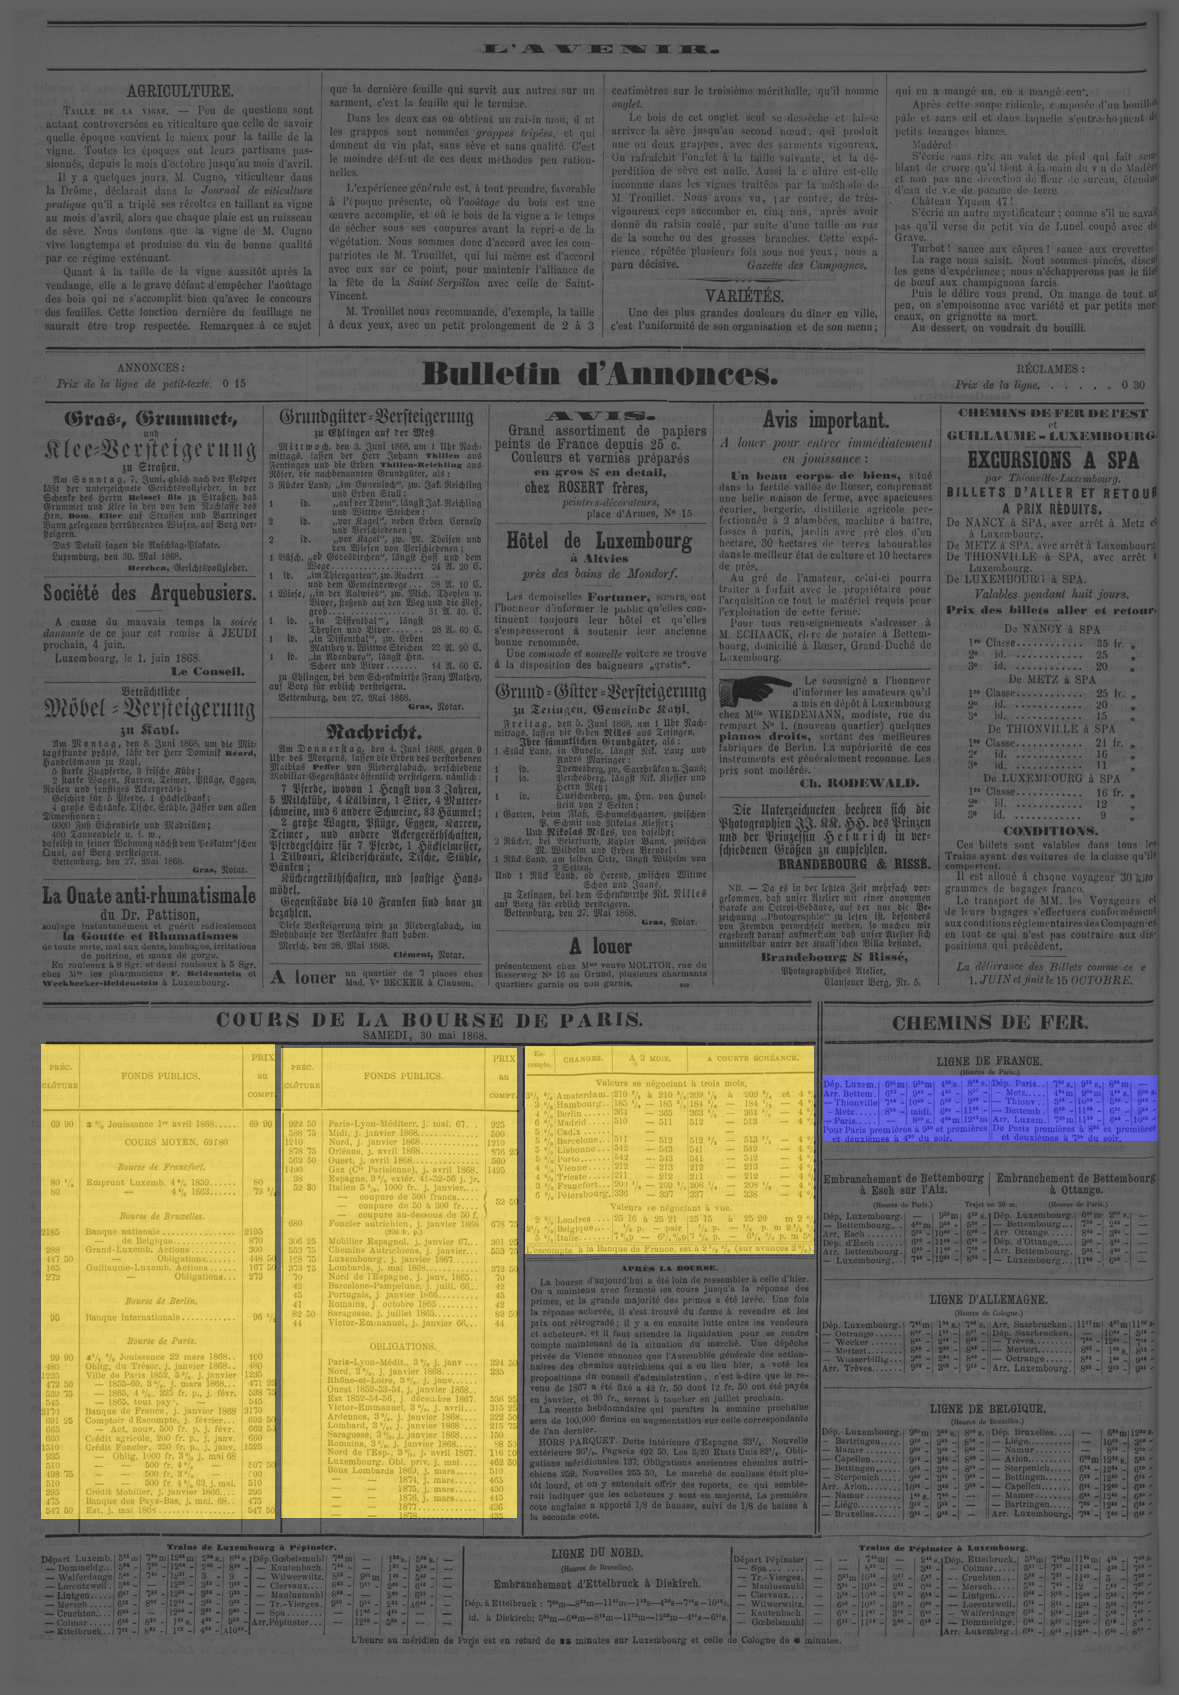

In [19]:
Image.fromarray(ground_truth)

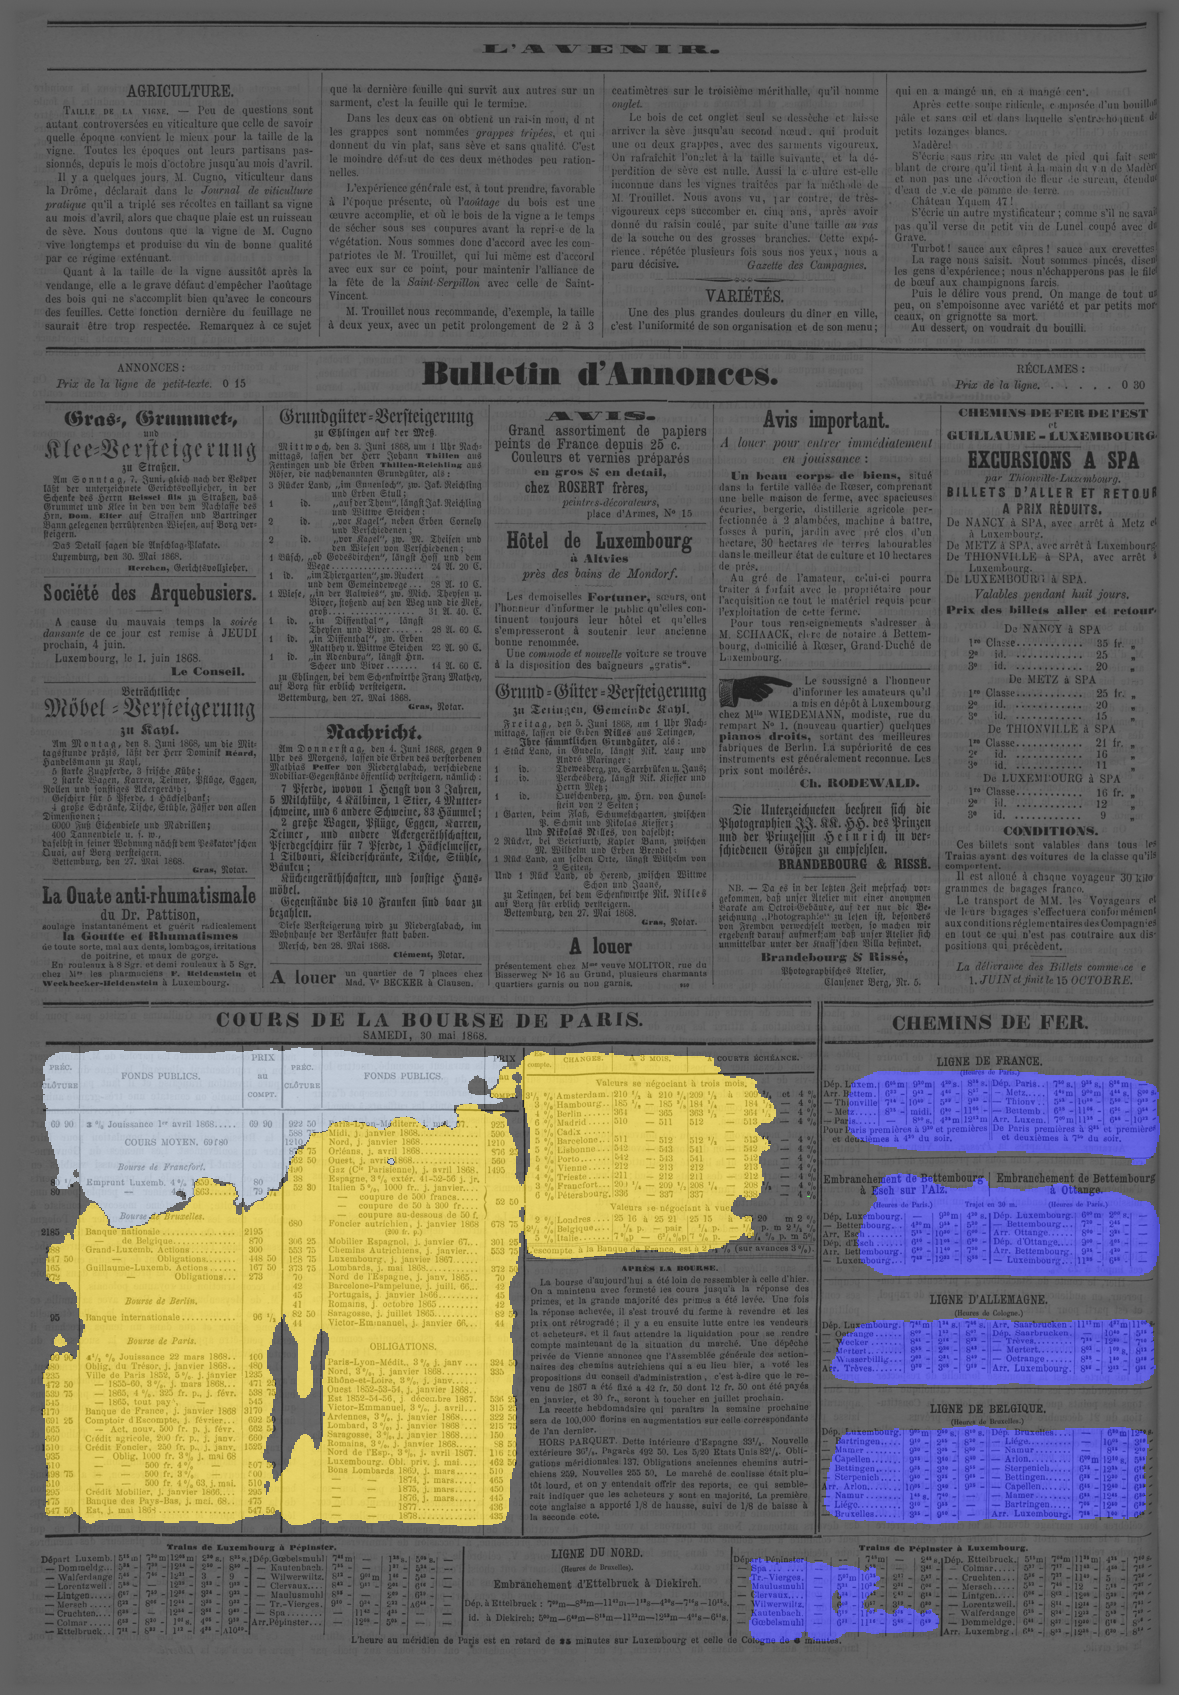

In [20]:
Image.fromarray(prediction)